In [ ]:
rm(list=ls())

In [ ]:
ls.str()

In [1]:
library(Seurat)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))

Attaching SeuratObject



In [2]:
library(future)
library(future.apply)
plan("multicore", workers = 10) 
options(future.globals.maxSize = 100 * 1024^3)

In [3]:
tmpdir <- paste0(getwd(), '/tmp/')
outdir <- paste0(getwd(), '/output/')
if(!dir.exists(tmpdir)) dir.create(tmpdir)
if(!dir.exists(outdir)) dir.create(outdir)

In [4]:
filedir <- paste0(tmpdir, 'raw_standard_slist.Rds')
slist <- readRDS(filedir)

# 1、Harmony
- 占用内存少，速度快，但容易消除过度
- 对于异质性很大的不同数据集，比如不同病人的肿瘤细胞，考虑到生物学差异已经远远大于批次效应，或许不应该再进行批次效应的去除
- Harmony适合小分群

## （1）先直接merge
- 若列名只有barcode，需要添加来源以便区分（病人信息、标本类型等）（RenameCells：add.cell.id）

In [ ]:
sce.all <- merge(x=slist[[1]], y=slist[-1], project = 'merge')    #x：Seurat对象；y：Seurat对象或列表

In [ ]:
# step1重新运行保存过后可删除此行
sce.all$orig.ident <- paste(sce.all$Patient, sce.all$Source, sep = "_")
sce.all@meta.data$barcode <- rownames(sce.all@meta.data)

In [ ]:
# 去除细胞周期影响，避免聚类时由于周期聚为一类
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
sce.all <- CellCycleScoring(sce.all, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
sce.all@meta.data %>% head()

In [ ]:
# 有批次效应时PC可选最大的50个
sce.all <- NormalizeData(sce.all, verbose = F) 
sce.all <- FindVariableFeatures(sce.all, selection.method = "vst", nfeatures = 2000)
sce.all <- ScaleData(sce.all, vars.to.regress = c("percent.mt","S.Score","G2M.Score"), verbose = F)
sce.all <- RunPCA(sce.all, verbose = F, npcs = 50)


In [ ]:
# 以下标准流程若用Harmony整合可不运行
#pc.num = 1:50
#sce.all <- FindNeighbors(sce.all, dims = pc.num)
#sce.all <- FindClusters(object = sce.all, resolution = 0.5)
#sce.all <- RunUMAP(object = sce.all, dims = pc.num)
#DimPlot(sce.all, reduction = "umap", label = TRUE, group.by="Source")

## （2）运行Harmony

In [ ]:
library(harmony)

In [ ]:
sce.all <- RunHarmony(sce.all, group.by.vars = c("orig.ident"), plot_convergence = TRUE)

In [ ]:
# 提取Harmony的Embeddings矩阵（坐标），可用于绘图
embeddings <- Embeddings(sce.all, 'harmony')

In [ ]:
pc.num = 1:50
sce.all <- FindNeighbors(sce.all, reduction = 'harmony', dims = pc.num)
sce.all <- FindClusters(sce.all, resolution = 1.5)
sce.all <- RunUMAP(sce.all, reduction = 'harmony', dims = pc.num)

In [ ]:
DimPlot(sce.all, reduction = "umap", label = T, group.by = "Source")  #颜色
DimPlot(sce.all, reduction = "umap", label = T, split.by = "Source")  #分开

In [ ]:
table(sce.all$`RNA_snn_res.0.5`, sce.all$`RNA_snn_res.1.5`)

In [ ]:
saveRDS(sce.all, file = paste0(tmpdir, 'merge_harmony_sce.Rds'))

# 2、Seurat包整合（CCA、RPCA）

In [ ]:
library(future)
library(future.apply)
plan("multicore", workers = 50) 
options(future.globals.maxSize = 40 * 1024^3)

In [ ]:
# 对于不同样本先分别运行Seurat的标准流程到找Variable基因这一步，构建sce list
slist <- future_lapply(slist, function(x){
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [ ]:
anchors <- FindIntegrationAnchors(slist, dims = 1:20, reduction = "cca")    #可换成"cca"
sce <- IntegrateData(anchors, dims = 1:20, new.assay.name = "CCA")

In [ ]:
# 标准流程
DefaultAssay(sce) <- "CCA"
sce <- ScaleData(sce, features = rownames(sce))
sce <- RunPCA(sce, verbose = FALSE)
sce <- FindNeighbors(sce, dims = 1:20)
sce <- FindClusters(sce, resolution = 0.5)
sce <- RunUMAP(sce, dims = 1:20)
sce <- RunTSNE(sce, dims = 1:20)

In [ ]:
saveRDS(sce, file = paste0(tmpdir, 'merge_cca_sce.Rds'))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



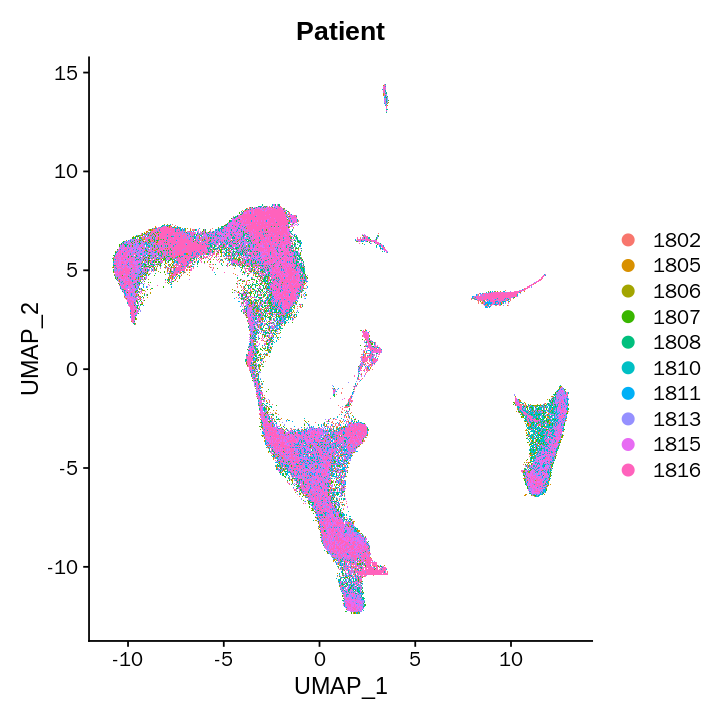

In [29]:
options(repr.plot.width=6, repr.plot.height=6)
DimPlot(sce, reduction = "umap", group.by = 'Patient')

In [ ]:
pbmc <- subset(sce, Source == 'PBMC')

In [ ]:
DimPlot(pbmc, reduction = "tsne", label = T)

# 取singlet进行CCA

In [14]:
for (i in 1:length(slist)){
  slist[[i]] <- subset(slist[[i]], doublets == "Singlet")
}

In [ ]:
slist <- future_lapply(slist, function(x){
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})
anchors <- FindIntegrationAnchors(slist, dims = 1:20, reduction = "cca", verbose = F)
sce <- IntegrateData(anchors, dims = 1:20, new.assay.name = "CCA", verbose = F)

In [51]:
DefaultAssay(sce) <- "RNA"
sce <- ScaleData(sce, features = rownames(sce), verbose = F)
sce <- RunPCA(sce, verbose = F)
sce <- FindNeighbors(sce, dims = 1:20, k.param = 20, verbose = F)
sce <- FindClusters(sce, resolution = 2, verbose = F)
sce <- RunUMAP(sce, dims = 1:20, min.dist = 0.1, verbose = F)

ERROR: Error in PrepDR(object = object, features = features, verbose = verbose): Variable features haven't been set. Run FindVariableFeatures() or provide a vector of feature names.


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



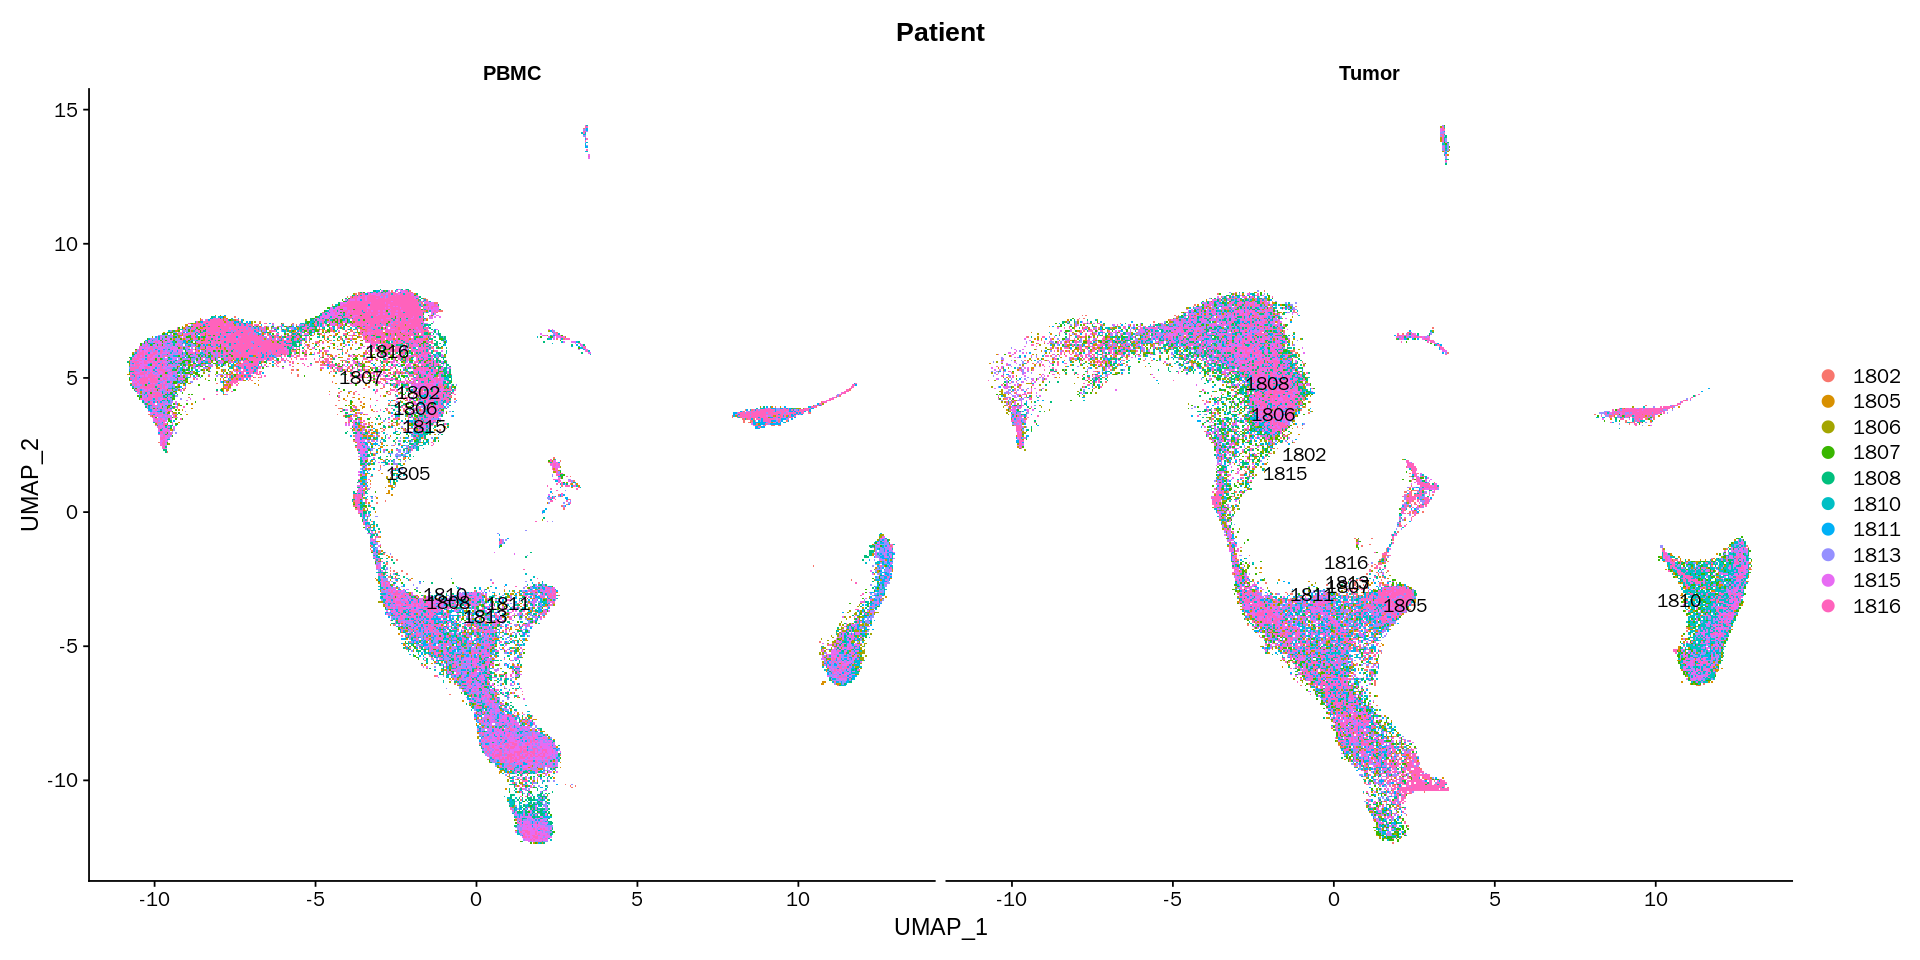

In [30]:
options(repr.plot.width=16, repr.plot.height=8)
DimPlot(sce, reduction = "umap", label = T, split.by = "Source", group.by = 'Patient')

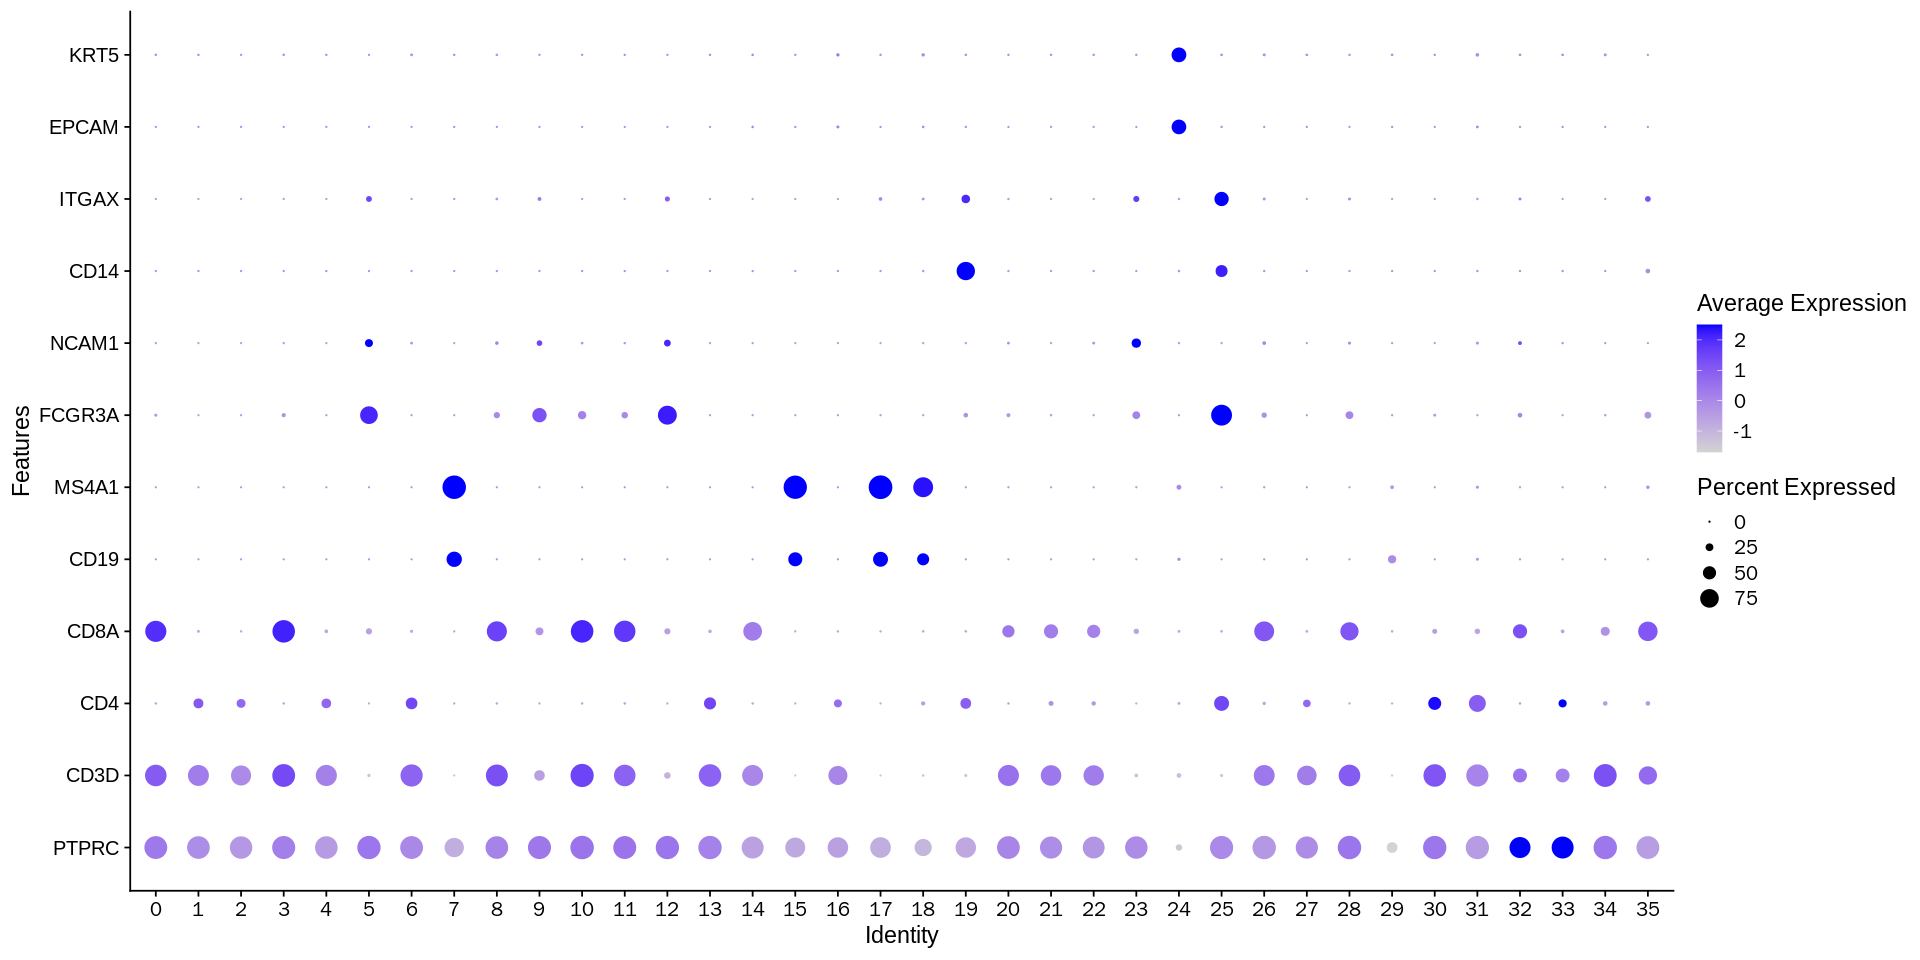

In [38]:
genes_to_check <- c('PTPRC', 'CD3D', 'CD4',  # CD4+T cells
                    'PTPRC', 'CD3D', 'CD8A',  # CD8+T cells
                    'CD19', 'MS4A1',  # B cells
                    'FCGR3A', 'NCAM1',  # NK cells
                    'CD14',  'ITGAX',  # myeloid
                    'EPCAM', 'KRT5'  # malignant
                   )
DotPlot(sce, features = unique(genes_to_check)) + coord_flip()

In [ ]:
cluster2celltype <- data.frame(cluster=levels(sce@meta.data$seurat_clusters), celltype='unknown')

cluster2celltype[cluster2celltype$cluster %in% c(0,3,8,10,11,14,20:22,26,28,32,34,35),2] <- 'CD8+T'
cluster2celltype[cluster2celltype$cluster %in% c(1,2,4,6,13,16,27,30,31,33),2] <- 'CD4+T'
cluster2celltype[cluster2celltype$cluster %in% c(5,9,12,23),2] <- 'NK'
cluster2celltype[cluster2celltype$cluster %in% c(7,15,17,18,29),2] <- 'Bcell'
cluster2celltype[cluster2celltype$cluster %in% c(19,25),2] <- 'Myeloid'
cluster2celltype[cluster2celltype$cluster %in% c(24),2] <- 'Malignant'

# cluster2celltype

# metadata新增一列
sce@meta.data$celltype <- cluster2celltype$celltype[match(sce@meta.data$seurat_clusters, cluster2celltype$cluster)]
head(sce@meta.data)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



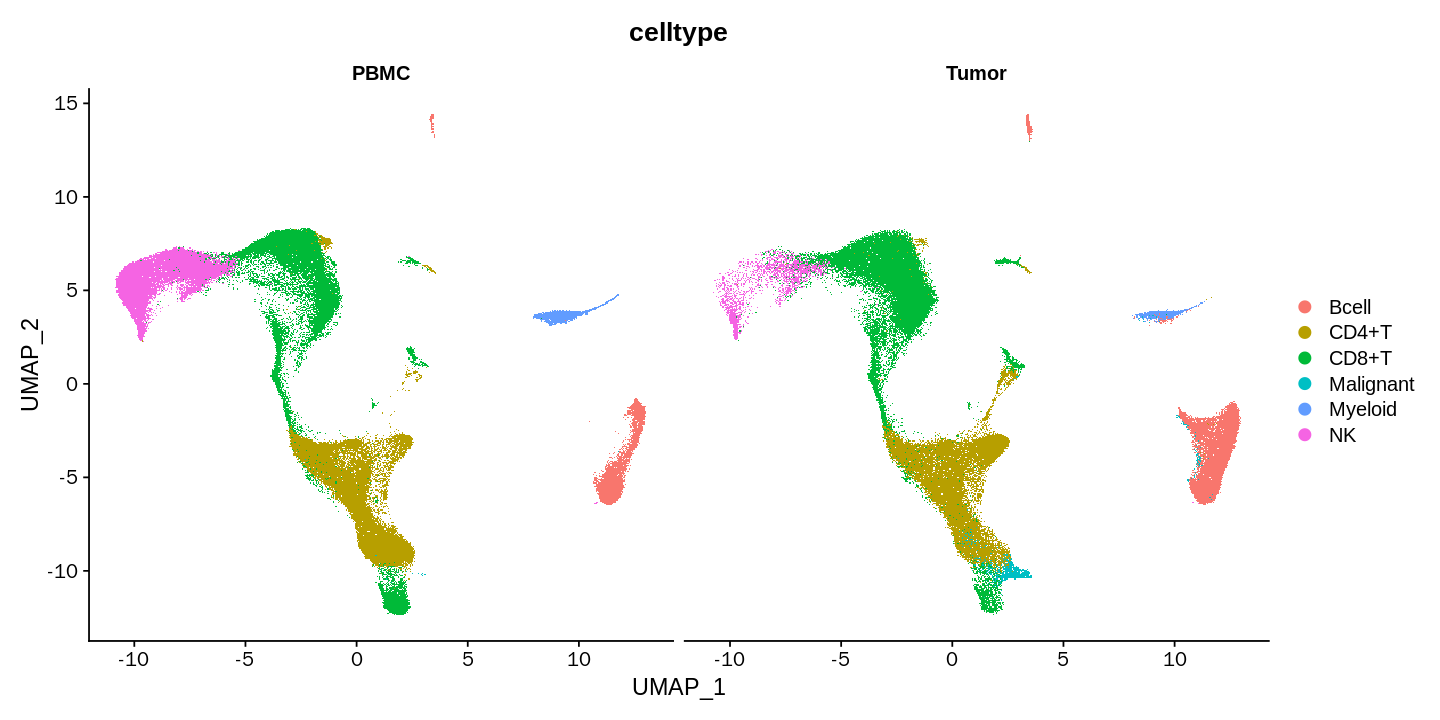

In [50]:
options(repr.plot.width=12, repr.plot.height=6)
DimPlot(sce, group.by = c("celltype"), split.by = 'Source')

In [ ]:
anchors <- FindIntegrationAnchors(slist, dims = 1:20, reduction = "rpca", verbose = F)
sce <- IntegrateData(anchors, dims = 1:20, new.assay.name = "RPCA", verbose = F)

In [ ]:
# SingleR自动注释
suppressPackageStartupMessages(library(SingleR))
hpca.se <- readRDS('/home/huangsw/scRNAseq/Annotation/hpca.Rds')
md <- sce@meta.data
AnnotData <- GetAssayData(sce, slot="data")  #标准化矩阵

AnnotInfo <- SingleR(test = AnnotData, ref = hpca.se, labels = hpca.se$label.main)
table(AnnotInfo$labels, md$seurat_clusters)
sce@meta.data$labels <- AnnotInfo$labels
DimPlot(sce, group.by = c("seurat_clusters", "labels"))

# 取子集

In [ ]:
dt <- sce.all@meta.data %>% group_by(orig.ident) %>% slice_sample(n = 500)
id2keep <- dt$barcode
sce <- subset(sce.all, barcode %in% id2keep)

In [ ]:
saveRDS(sce, file = paste0(tmpdir, 'subset_sce.Rds'))

In [ ]:
npc <- subset(sce.all, Source == 'Tumor')
pbmc <- subset(sce.all, Source == 'PBMC')

In [ ]:
saveRDS(npc, paste0(DFdir,"npc.Rds"))
saveRDS(pbmc, paste0(DFdir,"pbmc.Rds"))